In [1]:
# Features we used in the LessWrong post:

gelu_1l_feats = [8, 4542, 10996, 4958]
gelu_2l_feats = [8]  # in l1

In [88]:
# Load the SAE

import torch

from linearization.loading import load_sae, load_model
from linearization.analyzer import SAELinearizer
from linearization.visualization import visualize_topk

In [3]:
gelu_1l_sae = load_sae("run1")

Loading run1 from HuggingFace at 25
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}
Encoder device: cuda:0


In [4]:
f0 = gelu_1l_sae.W_enc[:, gelu_1l_feats[0]]

In [6]:
f0.shape

torch.Size([2048])

In [8]:
model = load_model("gelu-1l")

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0


In [66]:
# What's the highest cosine sim with out transcoders?
SEED = 43
N = 3

# Get residual stream representation of decoded f0
f0_dec_resid = gelu_1l_sae.W_dec[gelu_1l_feats[N], :] @ model.blocks[0].mlp.W_out

transcoder1 = torch.load(
    f"/home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt"
)
print(transcoder1["state_dict"]["W_dec"].shape)

f0_dec_resid_norm = f0_dec_resid / f0_dec_resid.norm()
W_dec_norm = transcoder1["state_dict"]["W_dec"] / transcoder1["state_dict"]["W_dec"].norm(dim=1, keepdim=True)

cos_sims = W_dec_norm.half() @ f0_dec_resid_norm
print(cos_sims.max(), cos_sims.argmax())

torch.Size([16384, 512])
tensor(0.7739, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>) tensor(1792, device='cuda:0')


In [70]:
# Now do it with encoder
SEED = 43
N = 3

# Get residual stream representation of decoded f0
f0_enc_resid = gelu_1l_sae.W_enc[:, gelu_1l_feats[N]] @ model.blocks[0].mlp.W_in.T

transcoder1 = torch.load(
    f"/home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt"
)
print(transcoder1["state_dict"]["W_enc"].shape)

f0_enc_resid_norm = f0_enc_resid / f0_enc_resid.norm()
W_enc_norm = transcoder1["state_dict"]["W_enc"] / transcoder1["state_dict"]["W_enc"].norm(dim=0, keepdim=True)

cos_sims = f0_enc_resid_norm @ W_enc_norm.half()
print(cos_sims.max(), cos_sims.argmax())

torch.Size([512, 16384])
tensor(0.1990, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>) tensor(2119, device='cuda:0')


In [72]:
# same for gelu-2l

gelu_2l_sae = load_sae("l1")
model = load_model("gelu-2l")

Loading l1 from HuggingFace at gelu-2l_L1_16384_mlp_out_50
{'act_name': 'blocks.1.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 512,
 'device': 'cuda:0',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 1,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 50,
 'seq_len': 128,
 'site': 'mlp_out'}
Encoder device: cuda:0
Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0


In [77]:
# What's the highest cosine sim with out transcoders?
SEED = 43

# Get residual stream representation of decoded f0
f0_dec_resid = gelu_2l_sae.W_dec[gelu_2l_feats[0], :]

transcoder1 = torch.load(
    f"/home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_2l/layer1/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-2l_blocks.1.ln2.hook_normalized_16384.pt"
)
print(transcoder1["state_dict"]["W_dec"].shape)

f0_dec_resid_norm = f0_dec_resid / f0_dec_resid.norm()
W_dec_norm = transcoder1["state_dict"]["W_dec"] / transcoder1["state_dict"]["W_dec"].norm(dim=1, keepdim=True)

cos_sims = W_dec_norm.half() @ f0_dec_resid_norm
print(cos_sims.max(), cos_sims.argmax())

torch.Size([16384, 512])
tensor(0.7041, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>) tensor(9258, device='cuda:0')


In [83]:
# Now do it with encoder
SEED = 43
N = 3

# Get residual stream representation of decoded f0
f0_enc_resid = gelu_1l_sae.W_enc[:, gelu_1l_feats[N]] @ model.blocks[0].mlp.W_in.T

transcoder1 = torch.load(
    f"/home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt"
)
print(transcoder1["state_dict"]["W_enc"].shape)

f0_enc_resid_norm = f0_enc_resid / f0_enc_resid.norm()
W_enc_norm = transcoder1["state_dict"]["W_enc"] / transcoder1["state_dict"]["W_enc"].norm(dim=0, keepdim=True)

cos_sims = f0_enc_resid_norm @ W_enc_norm.half()
print(cos_sims.max(), cos_sims.argmax())

torch.Size([512, 16384])
tensor(0.1769, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>) tensor(6460, device='cuda:0')


In [82]:
lin = SAELinearizer(
    "gelu-2l",
    "NeelNanda/pile-10k",
    [
        f"/home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt"
    ],
    [1],
    act_name="normalized",
    half_precision=False,
    run_analysis=False
)

Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda
Model device: cuda:0
Tokens shape: torch.Size([125337, 128]), dtype: torch.int64, device: cuda:0
Loading /home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_1l/seed43_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt from disk
Encoder device: cuda:0


In [86]:
lin.set_feature(
    9258, f"/home/phil/mlp_linearization/scripts/checkpoints/32x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt", num_batches=10
)

100%|██████████| 10/10 [00:00<00:00, 26.76it/s]


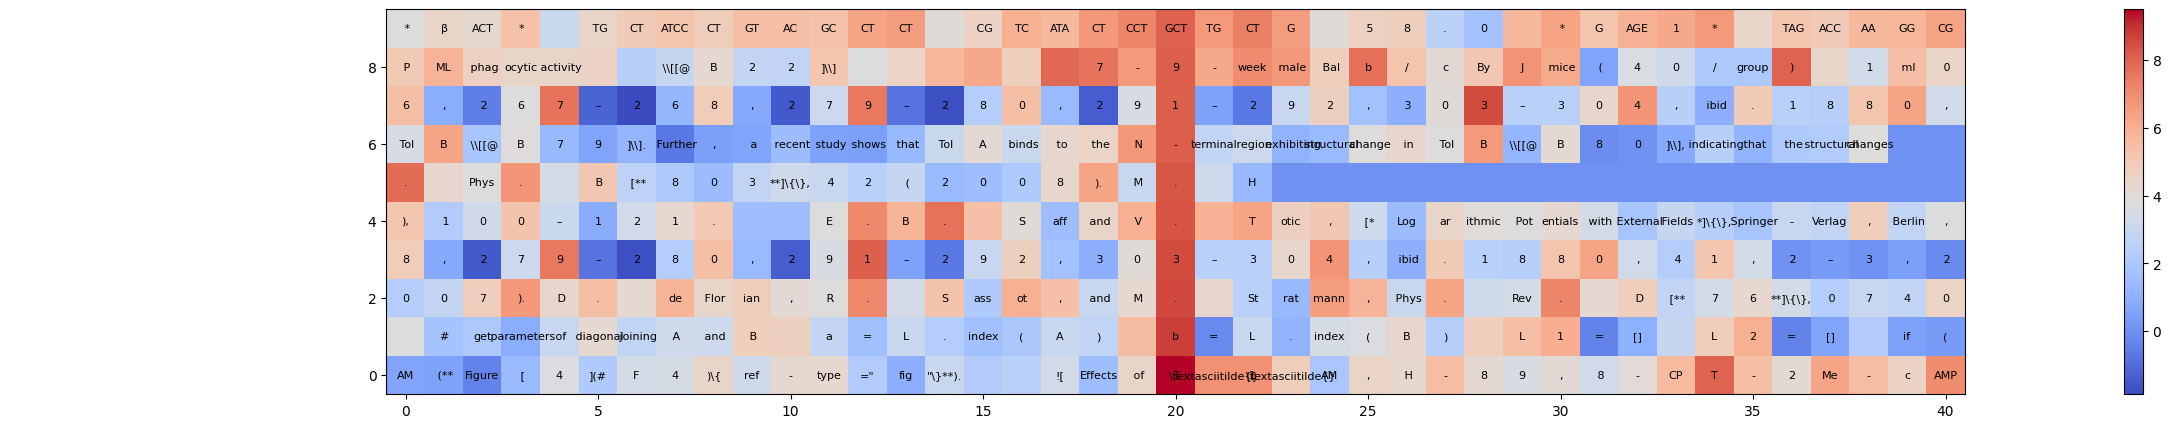

In [91]:
ax = visualize_topk(
    examples=lin.top_examples["examples"].detach().cpu().numpy(),
    activations=lin.top_examples["activations"].detach().cpu().numpy(),
    columns=lin.top_examples["cols"].detach().cpu().numpy(),
    model=lin.model,
    trim=20,
    zero_negatives=False,
)